In [1]:
from __future__ import print_function

import numpy as np
import cv2 as cv
import video
import sys
# import main()

import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf

In [2]:
printFlag = True
GREEN = (0,255,0)

In [3]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, GREEN)
    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(vis, (x1, y1), 1, GREEN, -1)
    return vis

In [4]:
def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    angle = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = angle * (180/np.pi/2)
    hsv[...,1] = 255
    # hsv[...,2] = np.minimum(v*4, 255)
    hsv[...,2] = cv.normalize(v, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return bgr

In [7]:
vid = "../video/stoneturntable1.mp4"
pixel_x, pixel_y = 0, 0
show_hsv, show_glitch = True, False
# vid = input("video_path: ")
# pixel_x, pixel_y = map(int, input('pixel location: ').split())
# show_hsv = map(bool, input("Show HSV?: "))
# show_glitch = map(bool, input("Show glitch?: "))

In [8]:
cam = video.create_capture(vid)  # cv.VideoCapture()
if not cam.isOpened():
    print("Camera open failed!")
    sys.exit()
# 캠의 속성값을 불러온다.
w = round(cam.get(cv.CAP_PROP_FRAME_WIDTH))
h = round(cam.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cam.get(cv.CAP_PROP_FPS) # 카메라에 따라 값이 정상적, 비정상적
# fourcc 값 받아오기, *는 문자를 풀어쓰는 방식, *'DIVX' == 'D', 'I', 'V', 'X'
fourcc = cv.VideoWriter_fourcc(*'DIVX')
# 1프레임과 다음 프레임 사이의 간격 설정
delay = round(1000/fps)
print(fps)

# 웹캠으로 찰영한 영상을 저장하기
# cv2.VideoWriter 객체 생성, 기존에 받아온 속성값 입력 
flowout = cv.VideoWriter('./recorded/'+ vid.rstrip('.mp4') +'_flow.avi', fourcc, fps, (w, h))
hsvout = cv.VideoWriter('./recorded/'+ vid.rstrip('.mp4') +'_hsv.avi', fourcc, fps, (w, h))

# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
_ret, prev = cam.read()
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prevgray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)

show_hsv = (show_hsv == 'True')
show_glitch = (show_glitch == 'True')
cur_glitch = prev.copy()
magnitude_array = np.array([])
loopcnt = 0
pixelflow = np.zeros((w, h))
print(np.shape(pixelflow))

[ WARN:0@61.826] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@61.826] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@61.826] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@61.826] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664

29.970029830932617
(1280, 720)



(<unknown>:14628): GStreamer-CRITICAL **: 20:53:20.641: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@62.196] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements

(<unknown>:14628): GStreamer-CRITICAL **: 20:53:20.686: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@62.198] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements


In [9]:
while True:
    loopcnt += 1
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    _ret, frame = cam.read()
    
    # prints image size
    # print(np.shape(frame))
    
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculates dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback

    # prev, next: 이전 영상과 현재 영상
    # flow: 계산된 옵티컬플로우
    # pyr_scale: 피라미드 영상 만들 때 축소 비율
    # levels: 피라미드 영상 개수
    # winsize: 평균 윈도우 크기
    # iterations: 각 피라미드 레벨에서 알고리즘 반복 횟수
    # poly_n: 다항식 확장을 위한 이웃 픽셀 크기. 보통 5 or 7.
    # poly_sigma: 가우시안 표준편차. 보통 poly_n = 5이면 1.1, poly_n = 7이면 1.5
    # flags: 0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN.
    # flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, pyr_scale = 0.5, \
    #                                    levels = 3, winsize = 15, iterations = 3, \
    #                                    poly_n = 5, poly_sigma = 1.2, flags = 0)
    flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    prevgray = gray
    
    ##### magnitude and angle #####

    # Print cartesian value of magnitude and angle
    magnitudeInCart = flow[..., 0]
    angleInCart = flow[..., 1]
    # if(printFlag):
        # print(magnitudeInCart, angleInCart)

    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True)
    polarFlow = np.stack([magnitude, angle], axis = 2)
    
    # Generating complex array for sound generation
    
    comp_polarFlow = np.vectorize(complex)(polarFlow[...,0], polarFlow[...,1])
    flat_comp_polarFlow = np.ravel(comp_polarFlow, order='C')
    # reduced = np.zeros((7
    
    ampphase = np.zeros_like(polarFlow)
    ampphase[..., 0] = polarFlow[..., 0] * np.cos(np.deg2rad(polarFlow[...,1]))
    ampphase[..., 1] = polarFlow[..., 0] * np.sin(np.deg2rad(polarFlow[...,1]))
    comp_ampphase = np.vectorize(complex)(ampphase[...,0], ampphase[...,1])
    print("asdf: ", comp_ampphase.dtype)
    flat_comp_ampphase = np.ravel(comp_ampphase, order='C')
    # print(flat_comp_ampphase.ndim)
    # if(printFlag):
        # print("magnitude: ", magnitude, "angle: ", angle)
        # print("shape: ", np.shape(magnitude), np.shape(angle))
        
    # prints out polarized magnitude and angle of input pixel position
    pixel_magnitude = magnitude[pixel_x, pixel_y]
    pixel_angle = angle[pixel_x, pixel_y]
    if(printFlag):
      print(pixel_magnitude, pixel_angle)
    magnitude_array = np.append(magnitude_array, pixel_magnitude)

    # prints out the average of polarized magnitude and angle
    avg_magnitude = np.average(magnitude)
    avg_angle = np.average(angle)
    # if printFlag:
        # print(avg_magnitude, avg_angle)
        
    reshaped = flat_comp_ampphase.reshape(-1, 1)
    ##### print #####  
    if loopcnt == 1:
        stacked = reshaped
    else: 
        stacked = np.concatenate([stacked, reshaped], axis = 1)
    
    if loopcnt == 10:
        print(np.shape(flow))
        print(flow)
        print(np.shape(magnitude))
        print(magnitude)
        print(np.shape(angle))
        print(angle)
        print(np.shape(polarFlow))
        print(polarFlow)
        print(np.shape(comp_polarFlow))
        print(comp_polarFlow)
        print(np.shape(comp_ampphase))
        print(comp_ampphase)
        print(np.shape(flat_comp_polarFlow))
        print(flat_comp_polarFlow)
        print(np.shape(flat_comp_ampphase))
        print(flat_comp_ampphase)
    if loopcnt == 150:
        print(stacked)
        print(np.shape(stacked))
        break
    # flowout.write(draw_flow(gray, flow))
    # hsvout.write(draw_hsv(flow))
    # cv.imshow('flow', draw_flow(gray, flow))
    # if show_hsv:
    #     cv.imshow('flow HSV', draw_hsv(flow))
    # if show_glitch:
    #     cur_glitch = warp_flow(cur_glitch, flow)
    #     cv.imshow('glitch', cur_glitch)
    ch = cv.waitKey(1)
    if ch == ord('q'):
        break
    if ch == ord('1'):
        show_hsv = not show_hsv
        print('HSV flow visualization is', ['off', 'on'][show_hsv])
    if ch == ord('2'):
        show_glitch = not show_glitch
        if show_glitch:
            cur_glitch = frame.copy()
        print('glitch is', ['off', 'on'][show_glitch])

asdf:  complex128
1.6168752e-06 107.51117
asdf:  complex128
0.0 0.0
asdf:  complex128
0.0 0.0
asdf:  complex128
0.0 0.0
asdf:  complex128
1.6168752e-06 107.51117
asdf:  complex128
0.0018916782 66.11891
asdf:  complex128
0.00016873404 249.85168
asdf:  complex128
1.0091708e-08 31.496433
asdf:  complex128
0.0012226638 335.11395
asdf:  complex128
0.0006449844 182.32819
(720, 1280, 2)
[[[-6.44451706e-04 -2.62066023e-05]
  [-6.73428236e-04  1.31928427e-05]
  [-1.05784670e-03  8.13058214e-05]
  ...
  [-9.05723064e-05  5.89531446e-05]
  [-5.42476009e-05  3.49114962e-05]
  [-2.86476770e-05  2.15146538e-05]]

 [[-7.12704437e-04 -4.09173226e-05]
  [-7.05976970e-04 -5.45629291e-07]
  [-1.14179438e-03  6.61681770e-05]
  ...
  [-7.46395526e-05  6.43398671e-05]
  [-4.77305330e-05  3.93625596e-05]
  [-2.83804002e-05  2.30358000e-05]]

 [[-6.98320218e-04 -3.89930647e-05]
  [-7.04148784e-04  4.50302423e-07]
  [-1.14365155e-03  6.39236532e-05]
  ...
  [-8.70488002e-05  7.04700651e-05]
  [-6.13451994e-05 

In [10]:
print(np.abs(stacked))
print(np.min(np.abs(stacked)))
print(np.max(np.abs(stacked)))

[[1.61687521e-06 0.00000000e+00 0.00000000e+00 ... 2.36631394e-04
  2.03836768e-04 4.19457936e-04]
 [2.31488395e-06 0.00000000e+00 0.00000000e+00 ... 5.55518651e-04
  3.94062952e-04 7.21075944e-04]
 [3.28696986e-06 0.00000000e+00 0.00000000e+00 ... 7.66342114e-04
  5.29704838e-04 8.91111108e-04]
 ...
 [1.03718447e-05 1.03718447e-05 1.03718447e-05 ... 1.80558381e-03
  3.29285250e-05 2.45302699e-03]
 [1.10592546e-05 1.10592546e-05 1.10592546e-05 ... 9.95083340e-04
  3.22714142e-05 1.39699667e-03]
 [1.06408223e-05 1.06408223e-05 1.06408223e-05 ... 3.64832087e-04
  2.57731803e-05 5.37053736e-04]]
0.0
104.08127392170162


In [11]:
istfted = librosa.istft(stacked)
print(istfted)
np.nan_to_num(istfted, copy=False)
print(np.shape(istfted))
print(istfted)

[-2.56001043e-08  1.97236123e-07 -2.07630208e-07 ...  1.18529035e-04
 -7.54822613e-05  1.08932735e-04]
(68659051,)
[-2.56001043e-08  1.97236123e-07 -2.07630208e-07 ...  1.18529035e-04
 -7.54822613e-05  1.08932735e-04]


In [12]:
ccropped = np.where(istfted>0)
print(ccropped)
print(np.shape(ccropped))
print(type(ccropped))
list = np.asarray(ccropped)
print(list)
print(np.shape(list))
print(type(list))
change = list.reshape(-1)
print(change)
print(np.shape(change))
print(type(change))

x = 10
y = 10
cnt = 22050 * y
cropped = np.zeros((22050 * x))
while cnt < 22050 * (x + y):
    cropped[cnt - 22050 * y] = istfted[change[cnt]]
    cnt+=1

print(cropped)
print(np.shape(cropped))
fs = 22050
sf.write('test.wav', cropped, fs)
ipd.Audio(cropped, rate=fs)
# librosa.display.waveshow(cropped, sr=fs)

(array([       1,        3,        5, ..., 68659047, 68659048, 68659050]),)
(1, 34334024)
<class 'tuple'>
[[       1        3        5 ... 68659047 68659048 68659050]]
(1, 34334024)
<class 'numpy.ndarray'>
[       1        3        5 ... 68659047 68659048 68659050]
(34334024,)
<class 'numpy.ndarray'>
[5.21317409e-08 4.60394581e-08 4.50827925e-08 ... 6.69604983e-08
 6.59903126e-08 6.46778570e-08]
(220500,)


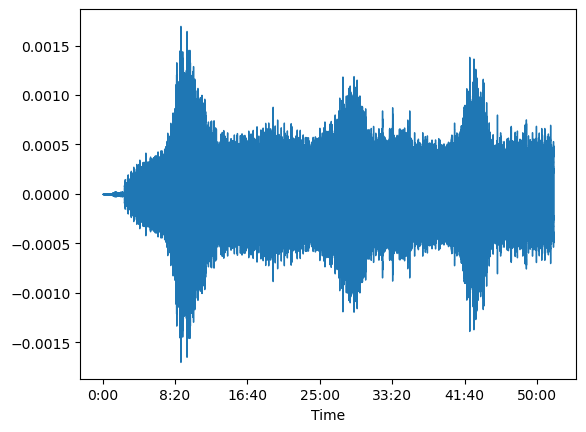

In [13]:
# fs = 460800
# fs = 691200
fs = 22050
sf.write('test.wav', istfted, fs)
ipd.Audio(istfted, rate=fs)
librosa.display.waveshow(istfted, sr=fs)
# sr = 30
# D = np.abs(stacked)
# S_dB = librosa.power_to_db(D, ref=np.max)
# img = librosa.display.specshow(S_dB, y_axis='linear', x_axis='time', hop_length=1, sr=30)
# plt.colorbar(format='%2.0f dB')
# plt.show()

In [14]:
cam.release()
flowout.release()
hsvout.release()
# fs = loopcnt
# freq = magnitude_array
# x1 = np.sin(2*np.pi*freq*np.arange(freq)/fs)
# ipd.Audio(x1, rate = fs)
print(magnitude_array)
print(loopcnt)
print('Done')

[1.61687524e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61687524e-06 1.89167820e-03 1.68734041e-04 1.00917079e-08
 1.22266379e-03 6.44984422e-04 8.63542547e-04 1.63567485e-04
 3.12509094e-08 8.59724423e-06 8.50246124e-06 2.28955884e-07
 2.28865517e-07 2.28955884e-07 2.28955884e-07 8.50254855e-06
 2.28955884e-07 2.28955884e-07 2.28955884e-07 8.57474879e-06
 2.28955884e-07 2.28955884e-07 2.28955884e-07 2.28955884e-07
 2.28955884e-07 2.28955884e-07 2.28955884e-07 2.28955884e-07
 2.28956395e-07 2.28955884e-07 2.28955884e-07 2.28955884e-07
 2.28955884e-07 2.28955884e-07 8.50254855e-06 2.28955884e-07
 2.28955884e-07 2.28955884e-07 2.28955884e-07 2.28955884e-07
 2.28955884e-07 2.28955884e-07 2.28955884e-07 2.28955884e-07
 8.57474879e-06 2.28955884e-07 2.28955884e-07 2.28955884e-07
 2.28956395e-07 2.28955969e-07 2.28955884e-07 2.28686872e-07
 2.28955884e-07 6.21058916e-06 5.24080519e-07 3.65275900e-11
 3.13520054e-08 1.03700395e-10 3.13730446e-08 7.02944786e-11
 3.13517425e-08 3.135172